In [1]:
from utility_dfplotter import *

# 1. Plot Nominal Distriubitons

In [2]:
def plotDataFrames():
    for seletion in ["emu","mumu","mutau","mu4j","ee","emu2","etau","e4j","mu4j_fakes","e4j_fakes"]:
        for nbjet in ["==1",">1"]:
            plotter = DFPlotter(seletion,nbjet)
            plotter.plotKinematics()
plotDataFrames()

making plots -- e4j_fakes nbjet>1: 24/24


# 2. Plot Z+Fake distributions 

In [12]:
def getDFList(faketype):
    
    # Diboson
    pickles  = glob.glob("../data/pickles/*_{}/mcdiboson/*.pkl".format(faketype))
    MCzz = pd.concat([ pd.read_pickle(pickle) for pickle in pickles ], ignore_index=True)
    # DY
    pickles  = glob.glob("../data/pickles/*_{}/mcdy/*.pkl".format(faketype))
    MCdy = pd.concat([ pd.read_pickle(pickle) for pickle in pickles], ignore_index=True)
    # tW
    pickles  = glob.glob("../data/pickles/*_{}/mct/*.pkl".format(faketype))
    MCt = pd.concat([ pd.read_pickle(pickle) for pickle in pickles], ignore_index=True)
    # tt
    pickles  = glob.glob("../data/pickles/*_{}/mctt/ntuple_ttbar_inclusive.pkl".format(faketype))
    MCtt = pd.concat([ pd.read_pickle(pickle) for pickle in pickles], ignore_index=True)

    # data
    pickles  = glob.glob("../data/pickles/*_{}/data2016/*.pkl".format(faketype))
    Data = pd.concat([ pd.read_pickle(pickle) for pickle in pickles], ignore_index=True)

    dfList = [MCt,MCtt,MCdy,MCzz,Data]
    
    for df in dfList:  
        df['passElISO'] = df.lepton3_iso>0
        df.lepton3_iso = df.lepton3_iso.abs()/df.lepton3_pt
        df.query('lepton3_pt>10',inplace=True)
        df.reset_index(drop=True,inplace=True)
    
    return dfList

def plotDFList(faketype):
    dfList = getDFList(faketype)
    pp = pd.read_csv("../scripts/plotterItemTables/itemTable_zl.csv")
    for index, row in pp.iterrows():
        v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
        sk = ASingleKinematicPlot(v,a,b,step,dfList)
        sk.settingPlot(xl, ['tW','tt','V+Jets','Diboson','Data'], ['C3','C2','C1','C0','k'])
        sk.makePlot('../plots/kinematics/z{}/'.format(faketype))
        
        print("making plots : {}/{}".format(index+1, len(pp)) )
        clear_output(wait=True)
        plt.close()
        
#plotDFList('e')

In [77]:
ls = getDFList('e')
fake,prompt,data = pd.concat(ls[0:3], ignore_index=True),ls[3],ls[4]

def ratioVar(up,down,upVar,downVar):
    ratio = up/down
    ratioVar = ratio**2
    ratioVar *= (upVar/up**2 + downVar/down**2)
    return ratioVar
    

#passIso = 'lepton3_iso<0.15'
#failIso = 'lepton3_iso>0.15'
passIso = 'passElISO==True'
failIso = 'passElISO==False'

ptbins  = [10,12,14,16,18,20,25,40,60]
records = []

for i in range(len(ptbins)-1):
    a,b = ptbins[i],ptbins[i+1]
    inPtBin = '& lepton3_pt>{} & lepton3_pt<{}'.format(a,b)
    
    ndataPass = sum(data.query(passIso+inPtBin).eventWeight)
    ndataFail = sum(data.query(failIso+inPtBin).eventWeight)
    npromptPass = sum(prompt.query(passIso+inPtBin).eventWeight)
    npromptFail = sum(prompt.query(failIso+inPtBin).eventWeight)
    nfakePass = sum(fake.query(passIso+inPtBin).eventWeight)
    nfakeFail = sum(fake.query(failIso+inPtBin).eventWeight)
    
    ndataPassVar = sum(data.query(passIso+inPtBin).eventWeight**2)
    ndataFailVar = sum(data.query(failIso+inPtBin).eventWeight**2)
    npromptPassVar = sum(prompt.query(passIso+inPtBin).eventWeight**2)
    npromptFailVar = sum(prompt.query(failIso+inPtBin).eventWeight**2)
    nfakePassVar = sum(fake.query(passIso+inPtBin).eventWeight**2)
    nfakeFailVar = sum(fake.query(failIso+inPtBin).eventWeight**2)
    
    records.append([a,b,
                    ndataPass, ndataFail, ndataPassVar, ndataFailVar,
                    npromptPass, npromptFail,npromptPassVar, npromptFailVar,
                    nfakePass, nfakeFail,nfakePassVar, nfakeFailVar
                   ])
    
df = pd.DataFrame.from_records(records, columns=['a','b',
                                                 'ndataPass', 'ndataFail', 'ndataPassVar', 'ndataFailVar',
                                                 'npromptPass', 'npromptFail', 'npromptPassVar', 'npromptFailVar',
                                                 'nfakePass', 'nfakeFail', 'nfakePassVar', 'nfakeFailVar'])

df['width'] = df.b - df.a
df['c'] = (df.b + df.a)/2
df['fakeRateData'] = (df.ndataPass - df.npromptPass)/(df.ndataFail - df.npromptFail)
df['fakeRateMC'] = df.nfakePass / df.nfakeFail

df['fakeRateDataSigma'] = ratioVar(df.ndataPass-df.npromptPass,
                                   df.ndataFail-df.npromptFail,
                                   df.ndataPassVar+df.npromptPassVar,
                                   df.ndataFailVar+df.npromptFailVar)**0.5

df['fakeRateMCSigma'] = ratioVar(df.nfakePass,df.nfakeFail,df.nfakePassVar,df.nfakeFailVar)**0.5

In [78]:
for i in range(len(df)):
    print('{:5.3f}+/-{:5.3f},{:5.3f}+/-{:5.3f}'.format(df.fakeRateData[i],df.fakeRateDataSigma[i],df.fakeRateMC[i],df.fakeRateMCSigma[i]))


0.055+/-0.005,0.046+/-0.006
0.060+/-0.006,0.076+/-0.009
0.070+/-0.008,0.066+/-0.009
0.057+/-0.008,0.055+/-0.009
0.065+/-0.010,0.102+/-0.017
0.084+/-0.010,0.097+/-0.010
0.125+/-0.013,0.108+/-0.012
0.250+/-0.040,0.147+/-0.023


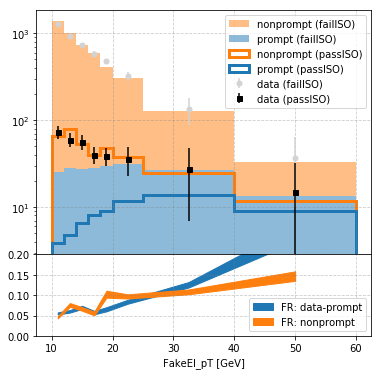

In [40]:
plt.rc("figure",facecolor="w")
fig, axes = plt.subplots(2, 1, sharex=True, 
                         gridspec_kw={'height_ratios':[3,1]},
                         figsize=(6,6))
fig.subplots_adjust(hspace=0)

ax = axes[0]

ax.hist([df.c,df.c],ptbins,
        weights=[df.npromptFail/df.width, df.nfakeFail/df.width],
        label=['prompt (failISO)','nonprompt (failISO)'],
        histtype='stepfilled',color=['C0','C1'],stacked=True,alpha=0.5)

ax.hist([df.c,df.c],ptbins,
        weights=[df.npromptPass/df.width, df.nfakePass/df.width],
        label=['prompt (passISO)','nonprompt (passISO)'],
        histtype='step',color=['C0','C1'],lw=3,stacked=True)#'skyblue','navajowhite'


ax.errorbar(df.c,df.ndataFail/df.width, 
            yerr = df.ndataFailVar**0.5,
            fmt='o', markersize=5,color = "lightgray",label='data (failISO)')

ax.errorbar(df.c, df.ndataPass/df.width,
            yerr = df.ndataPassVar**0.5,
            fmt='s',markersize=5, color="k", label='data (passISO)')

ax.legend()
ax.set_yscale('log')
ax.grid(color='grey',linestyle='--',alpha=0.4)
#ax.set_xlim(0.,100)

ax = axes[1]

ax.fill_between(df.c,df.fakeRateData+df.fakeRateDataSigma/2,df.fakeRateData-df.fakeRateDataSigma/2,color='C0', alpha=1,label='FR: data-prompt')
ax.fill_between(df.c,df.fakeRateMC+df.fakeRateMCSigma/2,df.fakeRateMC-df.fakeRateMCSigma/2,color='C1', alpha=1,label='FR: nonprompt')
#ax.axhline(0.05,c="k")
ax.legend(loc='lower right')
ax.set_ylim(0.,0.20)
#ax.set_xlim(0.,100)
ax.grid(color='grey',linestyle='--',alpha=0.4)
ax.set_xlabel('FakeEl_pT [GeV]')

plt.savefig('../plots/kinematicsWithFakes/e4j/fakerate.png',dpi=300)

# 2. Make Demo Plots

In [4]:
tr = "mu"

pickles  = glob.glob("../data/pickles/{}4j_fakes/data2016/*.pkl".format(tr))
Fakes = pd.concat([ pd.read_pickle(pickle) for pickle in pickles], ignore_index=True)
Fakes.query('lepton1_pt>30',inplace=True)
Fakes.reset_index(drop=True,inplace=True)

plotter = DFPlotter(tr+'4j','==1')

dfList     = [ Fakes ] + plotter.getDataFrameList()
labelList  = ['Fakes'] + plotter.labelList
colorList  = ['gray' ] + plotter.colorList
adjustList = [  0.05 ] + plotter.adjust

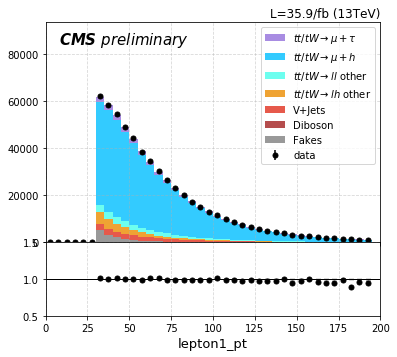

In [5]:
v,a,b,step,xl = "lepton1_pt",0,200,5,"lepton1_pt"
sk = ASingleKinematicPlot(v,a,b,step,dfList,adjust=adjustList)
sk.settingPlot(xl,labelList ,colorList )
sk.makePlot('../plots/kinematicsWithFakes/{}4j/'.format(tr))

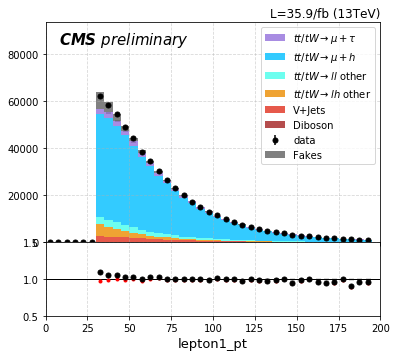

In [72]:
tr = "mu"

v,a,b,step,xl = "lepton1_pt",0,200,5,"lepton1_pt"

# make fake plot
plotter = DFPlotter(tr+'4j_fakes','==1')
sk = ASingleKinematicPlot(v,a,b,step,plotter.getDataFrameList())
sk.settingPlot(xl,plotter.labelList ,plotter.colorList )
sk.makePlot()

fakeProfile = sk.hdata - sk.mctot
fakeProfile
sk.axes[0].bar(sk.center,fakeProfile,sk.step,bottom=sk.mctot,color="gray",label="Fakes" )
sk.axes[0].legend()
plt.savefig('../plots/kinematicsWithFakes/{}4j/fakes.png'.format(tr),dpi=300)
plt.close()

# make nominal plot
plotter = DFPlotter(tr+'4j','==1')
sk = ASingleKinematicPlot(v,a,b,step,plotter.getDataFrameList())
sk.settingPlot(xl,plotter.labelList ,plotter.colorList )
sk.makePlot()

fakeProfile = fakeProfile*0.096
sk.axes[0].bar(sk.center,fakeProfile,sk.step,bottom=sk.mctot,color="gray",label="Fakes" )
sk.axes[0].legend()

sk.axes[1].plot(sk.center,sk.hdata/(fakeProfile+sk.mctot),'r.')
plt.savefig('../plots/kinematicsWithFakes/{}4j/nominal.png'.format(tr),dpi=300)

array([-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00,  1.71295605e+04,  1.17932724e+04,
        8.69530380e+03,  6.17228643e+03,  4.68793778e+03,  3.79516730e+03,
        2.86963575e+03,  2.36249243e+03,  2.01618284e+03,  1.58045256e+03,
        1.26115701e+03,  1.13368198e+03,  9.79161731e+02,  9.05920885e+02,
        7.52797525e+02,  6.27416715e+02,  5.95408708e+02,  5.34282630e+02,
        4.76274758e+02,  4.31128384e+02,  3.56951182e+02,  3.15660202e+02,
        2.99905174e+02,  2.74704348e+02,  2.38865025e+02,  2.20136195e+02,
        1.90455434e+02,  1.89752767e+02,  1.93148248e+02,  1.58209961e+02,
        1.51125368e+02,  1.51370216e+02,  1.19947713e+02])

In [21]:
v,a,b,step,xl = "lepton1_pt",0,200,5,"lepton1_pt"
tr = "e"
plotter = DFPlotter(tr+'tau','==1')
 
sk = ASingleKinematicPlot(v,a,b,step,plotter.getDataFrameList('ss'))
sk.settingPlot(xl, plotter.labelList, plotter.colorList)
sk.makePlot()
fakeProfile = sk.hdata-sk.mctot
sk.axes[0].bar(sk.center,fakeProfile,sk.step,bottom=sk.mctot,color="grey",label="unmodeled "+tr+"j" )
sk.axes[0].legend()
plt.savefig(tr+"tau_ss.png",dpi =300)
plt.close()

sk = ASingleKinematicPlot(v,a,b,step,plotter.getDataFrameList(''))
sk.settingPlot(xl, plotter.labelList, plotter.colorList)
sk.makePlot()
sk.axes[0].bar(sk.center,fakeProfile/1.15,sk.step,bottom=sk.mctot,color="grey",label="unmodeled "+tr+"j" )
sk.axes[0].legend()
plt.savefig(tr+"tau_os.png",dpi =300)
plt.close()

In [38]:
fakeProfile = sk.hdata-sk.mctot

In [23]:
fakeProfile

array([-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00,  1.58414262e+02,  1.05757785e+02,
        6.15076178e+01,  6.74549590e+01,  5.69652185e+01,  5.90822976e+01,
        4.26870025e+01,  7.64271981e+01,  3.44036272e+01,  2.26018865e+01,
        1.37224627e+00,  2.31671154e+01,  3.01520799e+01,  2.36737522e+00,
        2.41857980e+01,  1.97872735e+01,  7.46596887e+00,  5.48515298e+00,
       -9.26752293e-01,  5.34599265e+00, -3.32399978e+00, -2.48702963e+00,
        2.38585589e+00,  7.12616601e-02,  1.06471268e+00,  1.40373214e-01,
        3.52556199e+00, -2.55682318e-01, -8.34024140e-01,  8.81407211e-01,
        2.54636220e+00,  2.62578977e+00, -2.06837572e+00])